# Bottleneck layer + static grid sample - higher dimensionality

Ok, 1D works well but let's look at higher dimensionality, I want to get closer to more realistic computational units that we might find in a network.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 3006203676
set_all_seeds(seed)
print(seed)

3006203676


In [4]:
class config:
    # patient function model(s)
    N_FUNCS = 2
    FUNC_DIM = 2
    SCALE = 2
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 100
    MODEL_HIDDEN_DIM = 128

    # Embedder model
    N_SAMPLES = 128
    EPOCHS = 200
    BOTTLE_DIM = 4

## Train patient models

Going to create some 2D noise as functions to model.

In [66]:
from physics_mi.eval import *

import opensimplex
from functools import partial


def get_grid(n=32):
    x1, x2 = np.linspace(0, 1, n), np.linspace(0, 1, n)
    return x1, x2


def noise_func(x1, x2, seed, scale):
    opensimplex.seed(seed)
    x1, x2 = x1 * scale, x2 * scale
    return opensimplex.noise2array(x1, x2)


def plot_funcs(funcs):
    nrows = len(funcs) // 5 + 1
    ncols = min(len(funcs), 5)
    fig = plt.figure(figsize=(ncols * 3, nrows * 3))

    x1, x2 = get_grid(n=32)
    for i, func in enumerate(funcs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.pcolormesh(x1, x2, func(x1, x2))
        ax.set_aspect("equal")
        ax.set_title(f"Function {i}")


def generate_inputs(size):
    return np.random.rand(size, config.FUNC_DIM)


class FuncData:
    def __init__(self, func, size: int) -> None:
        self.func = func
        self.size = size
        self.X = generate_inputs(size)

        self.Y = self.func(self.X[:, 0], self.X[:, 1])
        self.X = np.stack(np.meshgrid(self.X[:, 0], self.X[:, 1])).T
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()
        self.Y = torch.as_tensor(self.Y).float()


def generate_func_data(funcs, train_size, valid_size):
    return [
        {
            "train": FuncData(func, train_size),
            "valid": FuncData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=config.FUNC_DIM, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 300  # number of epochs

    model = get_model()
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-5)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()
    y_targs = valid_data.Y.numpy()

    return y_preds, y_targs


def plot_models(df, data, title=None):
    fig = plt.figure(figsize=(15, 6))

    pdf = df.reset_index(drop=True)

    nrows = len(pdf) // 5 + 1
    ncols = min(len(pdf), 5)
    fig = plt.figure(figsize=(ncols * 3, nrows * 3))

    for i, row in pdf.iterrows():
        ax = fig.add_subplot(nrows, ncols, i + 1)
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[row["func"]]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        x1, x2 = valid_data.X.reshape(-1, 2).T.numpy()
        y = y_preds.T.reshape(-1)

        ax.scatter(x1, x2, s=5, label="Predicted", alpha=0.5, c=y_preds, cmap="viridis")

        _ = ax.set_title(f"Function {i}")

    if title is not None:
        fig.suptitle(title)

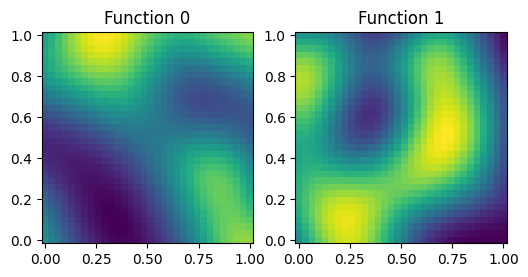

In [36]:
# data = generate_func_data(funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE)
seeds = [16 * i for i in range(config.N_FUNCS)]  # fudge factor to make them look nice
funcs = [partial(noise_func, seed=seed, scale=config.SCALE) for seed in seeds]
plot_funcs(funcs)

In [37]:
data = generate_func_data(funcs, int(np.sqrt(config.TRAIN_SIZE)), int(np.sqrt(config.VALID_SIZE)))

Due to limitations in the `opensimplex` library I'm using to create my functions I can only efficiently calculate the data on a more constrained grid (not truly randomly sampled). It will do I suppose:

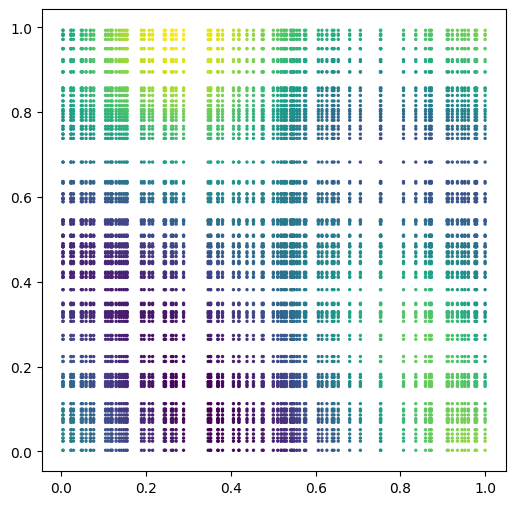

In [38]:
fd = data[0]["train"]

x, y = fd.X.reshape(-1, 2).T.numpy()
z = fd.Y.T.reshape(-1).numpy()

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=z, s=2, cmap="viridis")
ax.set_aspect("equal")

In [68]:
models = []
for i, (func, func_data) in tqdm(enumerate(zip(funcs, data)), total=len(data)):
    for j in tqdm(range(config.MODELS_PER_FUNC), leave=False):
        model, log = train_model(func_data["train"], func_data["valid"])
        row = {}
        row["func"] = i
        row["repeat"] = j
        row["model"] = model.state_dict()
        row["valid_loss"] = log["valid_loss"].iloc[-1]
        models.append(row)
    print("\n")

mdf = pd.DataFrame(models)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1500x600 with 0 Axes>

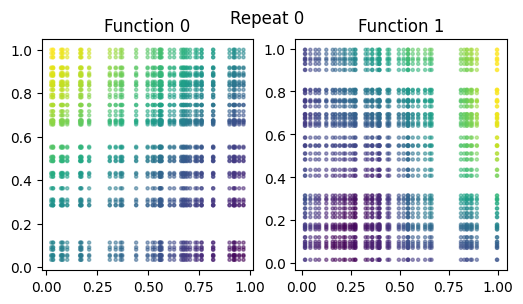

<Figure size 1500x600 with 0 Axes>

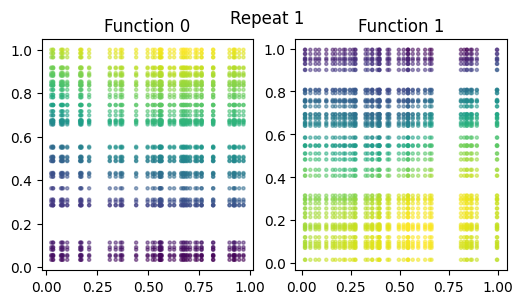

<Figure size 1500x600 with 0 Axes>

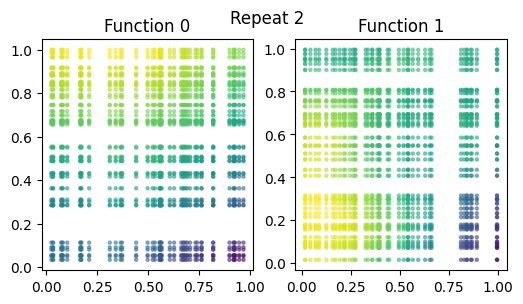

<Figure size 1500x600 with 0 Axes>

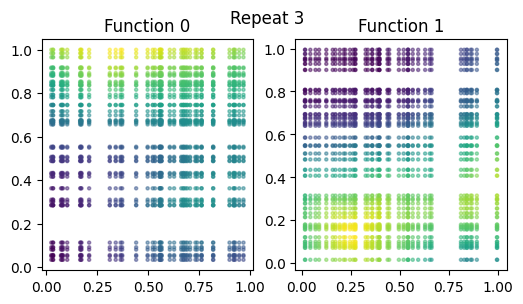

<Figure size 1500x600 with 0 Axes>

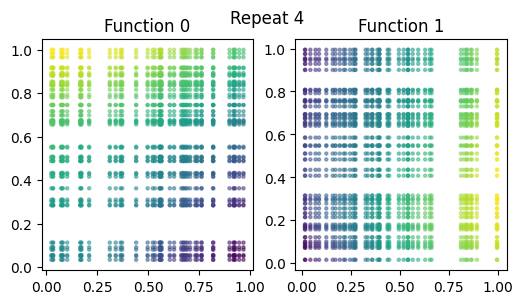

In [69]:
for i in range(5):
    _ = plot_models(mdf.loc[mdf["repeat"] == i * 2], data, title=f"Repeat {i}")

Ok so we can see that there is some underfitting (could probably have increased model capacity/decreased number of fourier components) but importantly, the shape between repeats seems to be fairly consistent (and distinct) 👍 which is what we need for the next model to learn distinguishing features.

In [70]:
models_name = f"simplex_models_{config.N_FUNCS}"
# mdf.to_pickle(f"models/{models_name}.pkl")

## Train model embedder

Here's where it gets interesting.

So far we've trained 50 different networks to model each of our 10 1D polynomials. The plan now is to use these as training data for our auxiliary model i.e. the one that's going to be generating embeddings. 

### Data

In [76]:
mdf = pd.read_pickle(f"models/{models_name}.pkl")

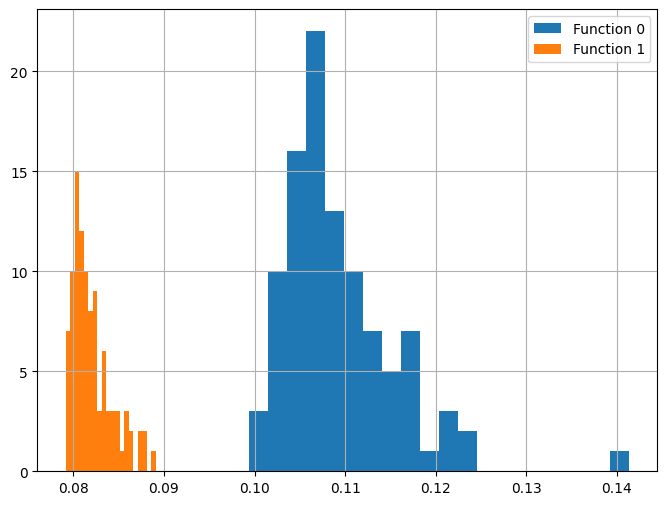

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))

for fn in range(config.N_FUNCS):
    mdf.loc[mdf["func"] == fn].valid_loss.hist(bins=20, ax=ax, label=f"Function {fn}")

_ = ax.legend()

Let's remove some of those high-loss models that probably aren't going to provide us with enough line sections to learn anything meaningful.

In [79]:
thresh = 0.13
(mdf.valid_loss < thresh).mean()

0.995

In [80]:
mdf = mdf.loc[mdf.valid_loss < thresh].reset_index(drop=True)
mdf.groupby("func")["func"].count()

func
0     99
1    100
Name: func, dtype: int64

Some functions were obviously harder to model than others.

In [ ]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(self, df: pd.DataFrame, n_samples: int = 10, mask: bool = True):
        self.df = df.reset_index(drop=True)
        self.n_samples = n_samples
        self.mask = mask

    def __len__(self) -> int:
        return len(self.df)

    def generate_X(self):
        X = torch.linspace(-1, 1, self.n_samples)[:, None]
        X.requires_grad_(True)
        return X

    def __getitem__(self, i):
        row = self.df.iloc[i]
        model = get_model()
        model.load_state_dict(row["model"])
        for param in model.parameters():
            param.requires_grad = False
        X = self.generate_X()
        out = model(X)
        loss = out.mean()
        loss.backward()
        input_grads = X.grad.clone().detach()
        if self.mask:
            uq_grads, _, _, index = unique(input_grads)
            uq_grads = uq_grads[torch.argsort(index)]
            n_grads = len(uq_grads)
            window_size = int(n_grads // 3)
            window_start = np.random.randint(0, n_grads - window_size)
            mask_grads = uq_grads[window_start : window_start + window_size]
            mask = torch.isin(input_grads, mask_grads)
            masked = input_grads.clone()
            masked[mask] = -1
            x = masked.view(-1)
        else:
            x = input_grads.view(-1)
        y = input_grads.view(-1)  # TODO potentially mask out the y values too in order to focus the loss
        x = x.detach()
        y = y.detach()
        return x, y

In [ ]:
from sklearn.model_selection import train_test_split

train_idxs, valid_idxs = train_test_split(mdf.index, test_size=0.2, stratify=mdf["func"], random_state=24)
mdf["valid"] = False
mdf.loc[valid_idxs, "valid"] = True

mdf.groupby("func")["valid"].value_counts()

In [ ]:
train_ds = GradientDataset(mdf.loc[~mdf["valid"]], n_samples=config.N_SAMPLES)
valid_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES)
eval_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES, mask=False)

len(train_ds), len(valid_ds), len(eval_ds)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)
eval_dl = DataLoader(eval_ds, batch_size=64, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

### Model

Going to add in a residual connection so that it can copy the unchanged grad inputs if it would like:

In [ ]:
class GradNet(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, bottle_dim=4, output_dim=2, embedding_mode=False, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.down_layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, bottle_dim, use_act=True),
        )
        self.up_layers = LinearLayer(bottle_dim, output_dim, use_act=True)
        self.output_layer = LinearLayer(output_dim, output_dim, use_act=False)
        self.embedding_mode = embedding_mode

    def forward(self, x):
        out = self.down_layers(x)
        if self.embedding_mode:
            return out
        out = self.up_layers(out)
        out = out + x  # residual connection
        return self.output_layer(out)

### Train

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

model = GradNet(input_dim=config.N_SAMPLES, hidden_dim=128, bottle_dim=config.BOTTLE_DIM, output_dim=config.N_SAMPLES)
optimiser = Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-2, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
        # loss = loss_func(y_hat[mask], yb[mask])
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            # valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])
            valid_loss += nn.MSELoss()(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

In [ ]:
torch.save(model.state_dict(), f"models/{models_name}.pth")

In [ ]:
plot_loss(log["train_loss"], log["valid_loss"])

In [ ]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb)
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [ ]:
y_preds, y_targs, X = get_preds(model, valid_dl)

X_grid = valid_ds.generate_X().detach().view(-1).numpy()
cloze_mask = X == -1
y_preds.shape, y_targs.shape, cloze_mask.shape

In [ ]:
i = 0

In [ ]:
fig, ax = plt.subplots()

func = funcs[valid_ds.df.loc[i, "func"]]

ax.plot(X_grid, y_preds[i], label="predicted")
ax.plot(X_grid, y_targs[i], label="target", color="orange")
ax.plot(X_grid[cloze_mask[i]], y_targs[i, cloze_mask[i]], color="red", label="masked")
_ = ax.legend()
i += 1

Ok, it's by no means perfect, but it's doing ok enough I think to move to the next stage: visualising the embeddings.

### Embedding visualisation

In [ ]:
embedder = GradNet(
    input_dim=config.N_SAMPLES,
    hidden_dim=128,
    bottle_dim=config.BOTTLE_DIM,
    output_dim=config.N_SAMPLES,
    embedding_mode=True,
)
embedder.load_state_dict(model.state_dict())

In [ ]:
y_preds, y_targs, X = get_preds(embedder, eval_dl)

In [ ]:
func_labels = valid_ds.df["func"].values
y_preds.shape, func_labels.shape

In [ ]:
from pacmap import PaCMAP

model = PaCMAP()

y_preds_2d = model.fit_transform(y_preds)

In [ ]:
fig, ax = plt.subplots()

for lbl in np.unique(func_labels):
    mask = func_labels == lbl
    ax.scatter(y_preds_2d[mask, 0], y_preds_2d[mask, 1], label=lbl, alpha=0.5)

ax.legend()
_ = ax.axis("off")

## Linear probing

These plots are nice and all but let's quantify this to see if they're linearly separable. Not sure if it's allowed to test on the training data when you're using a linear probe? Are you not just testing to see how linearly separable the data is? Is there an issue of overfitting?

In [ ]:
def train_linear_probe(X, y):
    model = nn.Linear(X.shape[1], len(np.unique(y)))
    optimiser = Adam(model.parameters(), lr=1)
    loss_func = nn.CrossEntropyLoss()
    X = torch.tensor(X).float()
    y = torch.tensor(y).long()
    log = []

    for epoch in tqdm(range(100)):
        log_sample = {}

        model.train()
        optimiser.zero_grad()
        y_hat = model(X)
        loss = loss_func(y_hat, y)
        loss.backward()
        optimiser.step()

        model.eval()
        y_hat = model(X)
        loss = loss_func(y_hat, y)
        log_sample["valid_loss"] = float(loss.detach())
        log.append(log_sample)

    return model, pd.DataFrame(log)


def top_k_accuracy(true_labels, predictions, k=1):
    """
    Computes the top-k accuracy for a given set of predictions and true labels.

    Parameters:
    - true_labels: numpy array of true labels.
    - predictions: numpy array of shape (num_samples, num_classes) containing the prediction scores for each class.
    - k: int, the top k predictions to consider for determining correctness.

    Returns:
    - top_k_acc: float, the top-k accuracy as a percentage.
    """
    # Get the indices of the top k predictions for each sample
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]

    # Check if the true label is among the top k predictions for each sample
    correct_predictions = np.any(top_k_predictions == true_labels[:, None], axis=1)

    # Calculate the top-k accuracy
    top_k_acc = np.mean(correct_predictions)

    return top_k_acc

Splitting my validation set into train and test for linear probe. Feels like overkill but might as well:

In [ ]:
lp_mdf = mdf.loc[mdf["valid"]].reset_index(drop=True)
lp_train_df, lp_valid_df = train_test_split(lp_mdf, test_size=0.5)
lp_train_df.reset_index(drop=True, inplace=True)
lp_valid_df.reset_index(drop=True, inplace=True)

lp_train_ds = GradientDataset(lp_train_df, n_samples=config.N_SAMPLES, mask=False)
lp_train_dl = DataLoader(lp_train_ds, batch_size=64, shuffle=False)

lp_valid_ds = GradientDataset(lp_valid_df, n_samples=config.N_SAMPLES, mask=False)
lp_valid_dl = DataLoader(lp_valid_ds, batch_size=64, shuffle=False)

In [ ]:
train_preds, _, _ = get_preds(embedder, lp_train_dl)
train_labels = lp_train_ds.df["func"].values
valid_preds, _, _ = get_preds(embedder, lp_valid_dl)
valid_labels = lp_valid_ds.df["func"].values

In [ ]:
linear_probe, lp_log = train_linear_probe(train_preds, train_labels)

In [ ]:
_ = plt.plot(lp_log["valid_loss"])

The valid dataloader isn't reproducible (for now) so I can use it to generate a new unseen set (dodgy I know... but it works).

In [ ]:
lp_preds = linear_probe(torch.tensor(valid_preds).float()).detach().numpy()

In [ ]:
top_k_accuracy(valid_labels, lp_preds, k=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid_labels, lp_preds.argmax(axis=1))

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()